In [6]:
import pyaudio
import wave
import speech_recognition as sr
import numpy as np
import tkinter as tk
from tkinter import messagebox
import sounddevice as sd
from scipy.fftpack import fft
from scipy.io.wavfile import write
import time

from tkinter.simpledialog import askstring
from matplotlib import pyplot as plt
from scipy.fft import fft
from tkinter import filedialog, messagebox
import scipy
from scipy.signal import butter, lfilter
import numpy as np
import tkinter as tk
from scipy import fftpack
import pyttsx3

In [7]:
SAMPLE_RATE = 8000  # Sample rate in Hz.
CHARACTER_DURATION = 0.04  # Duration of each character in seconds.
NUMBER_SAMPLES = int(SAMPLE_RATE * CHARACTER_DURATION)

font_name = "Arial"
font_size = 10  
button_font = (font_name, font_size)

# Encoding frequencies for each English character.
FREQUENCIES = {
    'a': [100, 1100, 2500], 'b': [100, 1100, 3000], 'c': [100, 1100, 3500],
    'd': [100, 1300, 2500], 'e': [100, 1300, 3000], 'f': [100, 1300, 3500],
    'g': [100, 1500, 2500], 'h': [100, 1500, 3000], 'i': [100, 1500, 3500],
    'j': [300, 1100, 2500], 'k': [300, 1100, 3000], 'l': [300, 1100, 3500],
    'm': [300, 1300, 2500], 'n': [300, 1300, 3000], 'o': [300, 1300, 3500],
    'p': [300, 1500, 2500], 'q': [300, 1500, 3000], 'r': [300, 1500, 3500],
    's': [500, 1100, 2500], 't': [500, 1100, 3000], 'u': [500, 1100, 3500],
    'v': [500, 1300, 2500], 'w': [500, 1300, 3000], 'x': [500, 1300, 3500],
    'y': [500, 1500, 2500], 'z': [500, 1500, 3000], ' ': [500, 1500, 3500]
}

def generate_character_signal(frequencies):
    character_signal = [
        np.cos(frequencies[0] * 2 * np.pi * n / SAMPLE_RATE) +
        np.cos(frequencies[1] * 2 * np.pi * n / SAMPLE_RATE) +
        np.cos(frequencies[2] * 2 * np.pi * n / SAMPLE_RATE)
        for n in range(NUMBER_SAMPLES)
    ]
    return character_signal

# Function to encode a string into a signal.
def encode_string_to_signal(input_string):
    signal = []
    for char in input_string:
        if char in FREQUENCIES: # if the character is in the dictionary.
            signal = np.concatenate((signal, generate_character_signal(FREQUENCIES[char])), axis=None)
        else:
            # If the character is not in the dictionary
            # add a some frequencies to the signal not in the dictionary.
            signal = np.concatenate((signal, generate_character_signal([600, 1600, 2600])), axis=None)
    return signal

# Function to get input string from the GUI text entry.
def get_input_string():
    input_text = text_entry.get("1.0", tk.END).strip().lower()
    if not input_text:
        messagebox.showerror("Error", "Please enter some text to encode.", font=(font_name, font_size))
        return
    return input_text

# Function to encode the input string and return the generated signal.
def encode():
    input_text = get_input_string()
    encoded_signal = encode_string_to_signal(input_text)
    return encoded_signal

def save_generated_signal():
    encoded_signal = encode()
    file_path = askstring('Name', 'Enter a name of file to save the generated signal:')
    if file_path and file_path[-4:] != ".wav":
        file_path += ".wav"
    if file_path:
        normalized_signal = np.int16((encoded_signal / encoded_signal.max()) * 32767)
        write(file_path, SAMPLE_RATE, normalized_signal)
        messagebox.showinfo("Success", f"File saved as {file_path}.")

# Function to play the generated signal and plot its time and frequency domains.
def play_generated_signal():
    # Generate the encoded signal.
    encoded_signal = encode()

    # Play the sound.
    sd.play(encoded_signal, SAMPLE_RATE)

    # Wait until sound has finished playing.
    time.sleep(1)

    # Plot the time and frequency domains of the signal.
    plot_signal(encoded_signal)

# Function to plot the time and frequency domains of a signal.
def plot_signal(signal):
    # Plotting
    plt.figure(figsize=(10, 6))

    # Time domain plot.
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot.
    time = np.linspace(0, len(signal) / SAMPLE_RATE, num=len(signal))

    plt.plot(time, signal)
    plt.title(f"Time Domain: Encoded Signal", font=font_name)
    plt.xlabel("Time (sec)", font=font_name)
    plt.ylabel("Amplitude", font=font_name)
    plt.grid(True)

    plt.subplot(2, 1, 2)
    N = len(signal)
    freq = np.fft.fftfreq(N, 1 / SAMPLE_RATE)
    freq = freq[:N // 2]
    magnitude = np.abs(fft(signal))[:N // 2]
    plt.plot(freq, magnitude)  # Plot only the positive frequencies.
    plt.title("Frequency Domain: Spectrum", font=font_name)
    plt.xlabel("Frequency (Hz)", font=font_name)
    plt.ylabel("Magnitude", font=font_name)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def record_audio(duration=5, filename="recorded.wav"):
    FORMAT = pyaudio.paInt16  # Format of sampling
    CHANNELS = 1  # Number of audio channels
    RATE = 44100  # Sampling rate
    CHUNK = 1024  # Chunk size for buffer
    RECORD_SECONDS = duration  # Duration of recording
    WAVE_OUTPUT_FILENAME = filename  # Output filename

    audio = pyaudio.PyAudio()  # Create pyaudio instantiation

    # Create pyaudio stream
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)
    print("Recording...")

    frames = []

    # Store data in chunks for RECORD_SECONDS
    for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("Finished recording.")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    # Terminate the PortAudio interface
    audio.terminate()

    # Save the recorded data as a WAV file
    with wave.open(WAVE_OUTPUT_FILENAME, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(audio.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

def audio_to_text(filename="recorded.wav"):
    recognizer = sr.Recognizer()
    with sr.AudioFile(filename) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
            print("Transcription: " + text)
            return text.lower()
        except sr.UnknownValueError:
            print("Google Speech Recognition could not understand audio")
            return None
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
            return None

# Function to record audio, convert it to text, and encode it.
def record_and_encode():
    record_audio()
    recorded_text = audio_to_text()
    if recorded_text:
        text_entry.delete('1.0', tk.END)
        text_entry.insert(tk.END, recorded_text)
        encoded_signal = encode_string_to_signal(recorded_text)
        return encoded_signal
    else:
        messagebox.showerror("Error", "Failed to transcribe the recorded audio.")

In [8]:
# Decoder functios




# Global variables.
global Uploaded_File_Successfully
Uploaded_File_Successfully=False
global File_Path
File_Path=None

# Audio processing parameters.
SAMPLE_RATE = 8000  # Sample rate in Hz.
CHARACTER_DURATION = 0.04  # Duration of each character in seconds.
NUMBER_SAMPLES = int(SAMPLE_RATE * CHARACTER_DURATION)
FFT_SIZE = 1024  # fft size.

# setup for the font used.
font_name = "Arial"
font_size = 10  
button_font = (font_name, font_size)

# Frequency ranges for each character.
FREQUENCIES = {
    'a': [100, 1100, 2500], 'b': [100, 1100, 3000], 'c': [100, 1100, 3500],
    'd': [100, 1300, 2500], 'e': [100, 1300, 3000], 'f': [100, 1300, 3500],
    'g': [100, 1500, 2500], 'h': [100, 1500, 3000], 'i': [100, 1500, 3500],
    'j': [300, 1100, 2500], 'k': [300, 1100, 3000], 'l': [300, 1100, 3500],
    'm': [300, 1300, 2500], 'n': [300, 1300, 3000], 'o': [300, 1300, 3500],
    'p': [300, 1500, 2500], 'q': [300, 1500, 3000], 'r': [300, 1500, 3500],
    's': [500, 1100, 2500], 't': [500, 1100, 3000], 'u': [500, 1100, 3500],
    'v': [500, 1300, 2500], 'w': [500, 1300, 3000], 'x': [500, 1300, 3500],
    'y': [500, 1500, 2500], 'z': [500, 1500, 3000], ' ': [500, 1500, 3500]
}

# Create a reverse mapping from frequencies to characters.
REVERSE_FREQUENCIES = {tuple(sorted(values)): key for key, values in FREQUENCIES.items()}

# Function to decode frequencies to characters.
def decode_frequencies(frequencies):
    frequencies = tuple(sorted(frequencies))
    # Return '?' for unknown frequencies.
    return REVERSE_FREQUENCIES.get(frequencies, '?')  

# Function to apply bandpass filter to data.
def bandpass_filter(data, lowcut, highcut, order=5):
    nyquist = 0.5 * SAMPLE_RATE
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Function to analyze audio segment with filters.
def analyze_segment_with_filters(segment):
    low=[50,1050,2450]
    high=[550,1550,3550]
    detected_frequencies = []
    for i in range(3):
        x = bandpass_filter(segment, low[i],high[i],order=1)
        detected_frequencies.append( np.argmax(abs(fftpack.fft(x, FFT_SIZE))) * (SAMPLE_RATE / FFT_SIZE) )
        detected_frequencies[i] = int(round(detected_frequencies[i] / 100) * 100)

    return detected_frequencies

# Function to decode audio file using filters.
def decode_audio_file_with_filters(file_path):
    # Read the audio file.
    x, data = scipy.io.wavfile.read(file_path)

    # Process in 40ms segments.
    segment_length = NUMBER_SAMPLES
    decoded_string = ''

    for start in range(0, len(data), segment_length):
        segment = data[start:start + segment_length]
        if len(segment) < segment_length:
            break
        frequencies = analyze_segment_with_filters(segment)
        character = decode_frequencies(frequencies)
        decoded_string += character

    return decoded_string


def analyze_segment_with_frequencies(segment):
    # Compute the Fourier transform.
    frequencies = np.fft.rfftfreq(len(segment), 1 / SAMPLE_RATE)
    magnitudes = np.abs(fft(segment))

    # Find the three highest amplitude frequencies.
    highest_freqs = sorted(zip(frequencies, magnitudes), key=lambda x: x[1], reverse=True)[:3]
    a=[freq for freq, mag in highest_freqs]
    return a

# Function to analyze audio segment using frequencies.
def decode_audio_file_with_frequencies(file_path):
    # Read the audio file.
    x,data = scipy.io.wavfile.read(file_path)
    # Normalize the data.
    data = data / np.max(np.abs(data))
    # Process in 40ms segments.
    segment_length = NUMBER_SAMPLES  # 40ms in samples.
    decoded_string = ''

    for start in range(0, len(data), segment_length):
        segment = data[start:start + segment_length]
        if len(segment) < segment_length:
            break
        frequencies = analyze_segment_with_frequencies(segment)
        character = decode_frequencies(frequencies)
        decoded_string += character

    return decoded_string

# Function to handle audio file upload.
def upload_audio_file():
    global File_Path
    File_Path = filedialog.askopenfilename(defaultextension=".wav", filetypes=[("WAV files", "*.wav")])
    if File_Path:
        global Uploaded_File_Successfully
        Uploaded_File_Successfully = True
        messagebox.showinfo("Success", f"File uploaded successfully")


# Function to decode audio file using frequencies and update GUI.
def decode_file_frequency():
    global Uploaded_File_Successfully
    if Uploaded_File_Successfully:
        decoded_string = decode_audio_file_with_frequencies(File_Path)
        result_text.delete('1.0', tk.END)
        result_text.insert(tk.END, decoded_string)
    else:
        messagebox.showinfo("Error", f"Please upload a file as a (.wav)")

# Function to decode audio file using filters and update GUI.
def decode_file_filters():
    global Uploaded_File_Successfully
    if Uploaded_File_Successfully:
        decoded_string = decode_audio_file_with_filters(File_Path)
        result_text.delete('1.0', tk.END)
        result_text.insert(tk.END, decoded_string)
    else:
        messagebox.showinfo("Error", f"Please upload a file as a (.wav)")

# Function to play the decoded text.
def play_decoded_text():
    decoded_text = result_text.get("1.0", tk.END).strip()
    if not decoded_text:
        messagebox.showerror("Error", "No text available to play.")
        return
    
    # Initialize the text-to-speech engine.
    engine = pyttsx3.init()
    engine.say(decoded_text)
    engine.runAndWait()

button_bg_color = "lightblue"
# Function to open a new window for decoding options.
def open_new_window():
    new_window = tk.Toplevel()
    new_window.title("Decoder Options")
    new_window.geometry("400x150")

    button1 = tk.Button(new_window, text="Decode using Frequency", command=decode_file_frequency, font=button_font, bg=button_bg_color)
    button1.pack(pady=5)

    button2 = tk.Button(new_window, text="Decode using Filter", command=decode_file_filters, font=button_font, bg=button_bg_color)
    button2.pack(pady=5)

    button3 = tk.Button(new_window, text="Play Decoded Text", command=play_decoded_text, font=button_font, bg=button_bg_color)
    button3.pack(pady=5)




Recording...
Finished recording.
Google Speech Recognition could not understand audio
Recording...
Finished recording.
Transcription: this is our DSP project


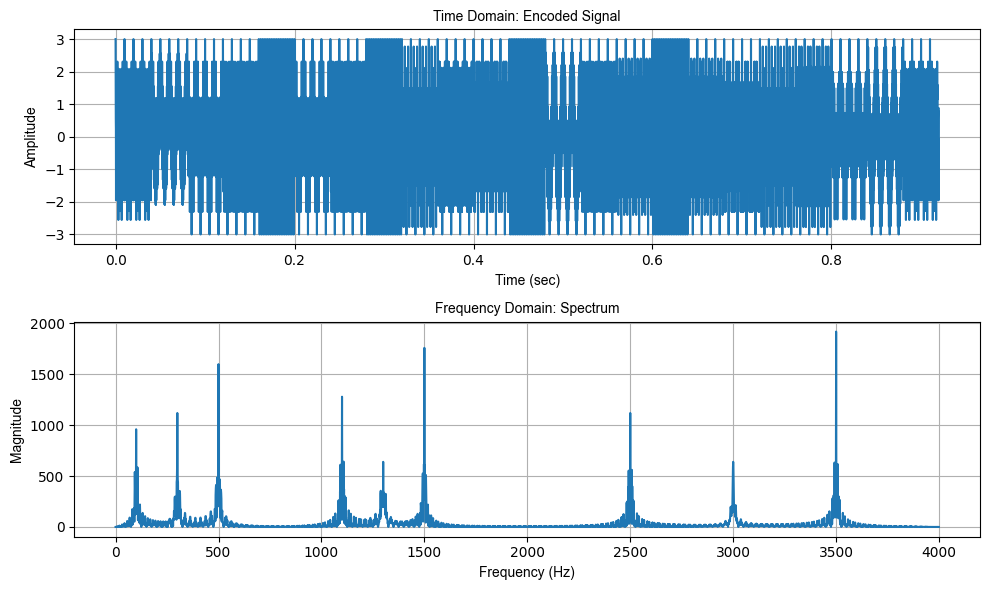

In [9]:
#Encoder
if __name__ == "__main__":
    # Create the main window.
    root = tk.Tk()
    root.title("Voice-Frequency Encoder")
    root.geometry("800x400")
    root.configure(bg="#f0f0f0")

    # Title label.
    title_label = tk.Label(root, text="Voice-Frequency Encoder", font=("Arial", 16, "bold"), bg="#f0f0f0")
    title_label.pack(pady=10)

    # Create a frame for text entry.
    text_frame = tk.Frame(root, bg="#f0f0f0", padx=10, pady=10, highlightbackground="gray", highlightthickness=1)
    text_frame.pack(pady=10)

    # Create a text entry widget.
    text_entry = tk.Text(text_frame, height=10, width=50, font=(font_name, 12), bg="#ffffff", bd=0)
    text_entry.pack()

    button_bg_color = "lightblue"

    # Create a frame for buttons.
    button_frame = tk.Frame(root, bg="#f0f0f0")
    button_frame.pack(pady=10)

    # Create a button to trigger the recording and encoding.
    record_button = tk.Button(button_frame, text="Record Audio and Encode", command=record_and_encode,
                              font=(font_name, font_size), bg=button_bg_color, padx=20, pady=10)
    record_button.grid(row=0, column=0, padx=10, pady=5)

    # Create a button to trigger the encoding and saving.
    save_button = tk.Button(button_frame, text="Save the generated signal as (.wav)", command=save_generated_signal,
                            font=(font_name, font_size), bg=button_bg_color, padx=20, pady=10)
    save_button.grid(row=0, column=1, padx=10, pady=5)

    # Create a button to trigger the play sound.
    play_button = tk.Button(button_frame, text="Play the generated signal", command=play_generated_signal,
                            font=(font_name, font_size), bg=button_bg_color, padx=20, pady=10)
    play_button.grid(row=0, column=2, padx=10, pady=5)

    credit_label = tk.Label(root, text="Project created by Faizer & Imran & Rifat", font=("Arial", 12), fg="gray", bg="#f0f0f0")
    credit_label.pack(pady=10)

    root.mainloop()

In [10]:
#Decoder

if __name__ == "__main__":
    # Create the main window
    root = tk.Tk()
    root.title("Voice-Frequency Decoder")
    root.geometry("600x400")
    root.configure(bg="#f0f0f0")
    # Title label.
    title_label = tk.Label(root, text="Voice-Frequency Decoder", font=("Arial", 16, "bold"), bg="#f0f0f0")
    title_label.pack(pady=10)
    

    # Create a text widget to display the output result
    result_text = tk.Text(root, height=10,width=50, font=(font_name, 12), bg="#ffffff")
    result_text.pack()

    # Add file upload button
    upload_button = tk.Button(root, text="Upload Audio File (.wav)", command=upload_audio_file, font=("Arial",12), bg=button_bg_color)
    upload_button.pack()

    # Add a button to open decoding options
    run_button = tk.Button(root, text="Run Decoder", command=open_new_window, font=("Arial",12), bg=button_bg_color)
    run_button.pack()
    # Mention project creators
    creator_label = tk.Label(root, text="Project created by Faizer & Imran & Rifat",font=("Arial", 12), fg="gray", bg="#f0f0f0")
    creator_label.pack()

    root.mainloop()